The task is to use CountVectorizer from Scikit-learn with various parameters.

In [1]:
import nltk
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from nltk import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet

In [2]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/valentine/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/valentine/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/valentine/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
# download BBC text classification dataset
# original dataset on Kaggle: https://www.kaggle.com/datasets/shivamkushwaha/bbc-full-text-document-classification)
!wget -nc https://lazyprogrammer.me/course_files/nlp/bbc_text_cls.csv

In [4]:
# save the dataset in Pandas dataframe
df = pd.read_csv('bbc_text_cls.csv')

In [5]:
# check the dataset
df.head(10)

,text,labels
0,Ad sales boost Time Warner profit\n\nQuarterly...,business
1,Dollar gains on Greenspan speech\n\nThe dollar...,business
2,Yukos unit buyer faces loan claim\n\nThe owner...,business
3,High fuel prices hit BA's profits\n\nBritish A...,business
4,Pernod takeover talk lifts Domecq\n\nShares in...,business
5,Japan narrowly escapes recession\n\nJapan's ec...,business
6,Jobs growth still slow in the US\n\nThe US cre...,business
7,"India calls for fair trade rules\n\nIndia, whi...",business
8,Ethiopia's crop production up 24%\n\nEthiopia ...,business
9,Court rejects $280bn tobacco case\n\nA US gove...,business


In [6]:
# save texts and labels
inputs = df['text']
labels = df['labels']

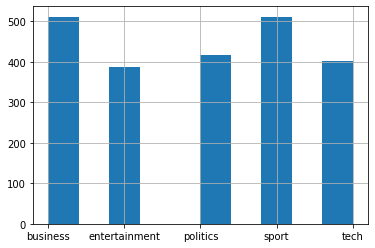

In [7]:
# check labels distribution: they don't seem too imbalanced
labels.hist()

In [8]:
# make train and test sets
inputs_train, inputs_test, Ytrain, Ytest = train_test_split(inputs, labels, random_state=123)

In [9]:
# part of speech mapping function for a custom tokenizer
def get_wordnet_pos(treebank_tag):
    mapping = {
        'J': wordnet.ADJ,
        'V': wordnet.VERB,
        'N': wordnet.NOUN,
        'R': wordnet.ADV
    }
    return mapping.get(treebank_tag[0], wordnet.NOUN)

In [10]:
# create a custom tokenizer based on lemmatization
class LemmaTokenizer():
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        words_and_tags = nltk.pos_tag(tokens)
        return [self.wnl.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in words_and_tags]

In [11]:
# create a custom tokenizer based on stemming
class StemTokenizer():
    def __init__(self):
        self.porter = PorterStemmer()
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        return [self.porter.stem(t) for t in tokens]

In [12]:
# create a dictionary of count vectorizers
vectorizers = {'default': CountVectorizer(),
               'with stopwords': CountVectorizer(stop_words='english'),
               'with lemmatization tokenizer': CountVectorizer(tokenizer=LemmaTokenizer()),
               'with stemming tokenizer': CountVectorizer(tokenizer=StemTokenizer()),
               'with splitting tokenizer': CountVectorizer(tokenizer=lambda s: s.split())
              }

In [13]:
# create a model and lists to keep the vectorizers types and scores
model = MultinomialNB()
vectorizers_names = []
time_scores = []
train_scores = []
test_scores = []

In [14]:
# create a function to use the vectorizer, fit the model and save the scores 
def count_vectorizer(v):
    vectorizer = v
    Xtrain = vectorizer.fit_transform(inputs_train)
    Xtest = vectorizer.transform(inputs_test)
    t0 = datetime.now()
    model.fit(Xtrain, Ytrain)
    dt = (datetime.now() - t0).total_seconds()
    train_score = model.score(Xtrain, Ytrain)
    test_score = model.score(Xtest, Ytest)
    time_scores.append(dt)
    train_scores.append(train_score)
    test_scores.append(test_score)

In [15]:
# apply the function to each vectorizer
for k, v in vectorizers.items():
    vectorizers_names.append(k)
    count_vectorizer(v)

In [16]:
# create a summary table
summary = pd.DataFrame({'time': time_scores, 'train score': train_scores, 'test score': test_scores},
                       index=vectorizers_names)

In [17]:
summary
# The count vectorizer with stopwords seems to have the best test score
# The vectorizers using linguistic tokenizers (lemmatization, stemming) have slightly worse test scores

,time,train score,test score
default,0.008768,0.992206,0.971275
with stopwords,0.007166,0.992806,0.976661
with lemmatization tokenizer,0.006932,0.992206,0.967684
with stemming tokenizer,0.006761,0.989209,0.969479
with splitting tokenizer,0.007776,0.995204,0.971275
